# 실습[05] 합성곱 신경망(1)- 나만의 CNN으로 MNIST 예측하기
휴먼지능정보공학과 201910805 백서희

## Github url: https://github.com/soycong

# Load packages

In [39]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

# MNIST train, test dataset 가져오기

In [40]:
# "": 현재 폴더에 MNIST 있음
mnist_train=dset.MNIST("", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test=dset.MNIST("", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

# 대략적인 데이터 형태

mnist_train 길이 60000
mnist_test 길이 10000
image data 형태: torch.Size([1, 28, 28])
label: 5


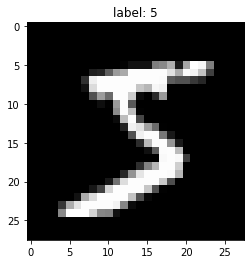

In [41]:
print("mnist_train 길이",len(mnist_train))
print("mnist_test 길이",len(mnist_test))

#데이터 하나 형태
image, label = mnist_train.__getitem__(0)
print("image data 형태:", image.size())
print("label:", label)

#그리기
img=image.numpy()
plt.title("label: %d" %label)
plt.imshow(img[0], cmap='gray')
plt.show()

# MINST data 띄워보기

5
torch.Size([1, 28, 28])
5


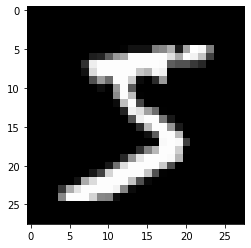

0


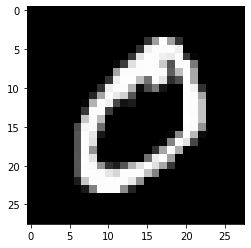

4


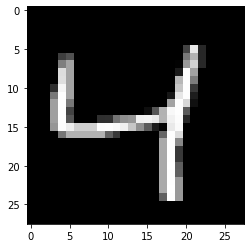

In [42]:
print(mnist_train[0][1])
print(mnist_train[0][0].size())

for i in range(3):
    img=mnist_train[i][0].numpy()
    print(mnist_train[i][1])
    plt.imshow(img[0], cmap='gray')
    plt.show()

# convolution 하나 씌워보기

torch.Size([1, 1, 28, 28])
5
torch.Size([1, 3, 28, 28])


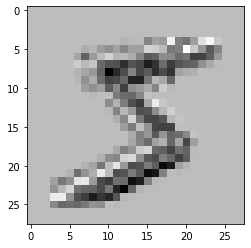

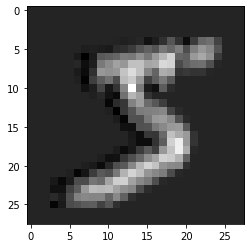

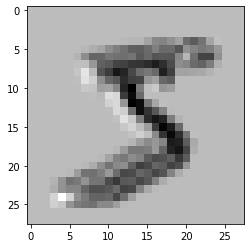

In [43]:
#mnist의 첫번째 이미지, 라벨 가져오기
image, label= mnist_train[0]
#view: tensor size 조절, -1: 해당 차원의 차원을 확장시켜라
#[1, 28, 28] -> [1, 1, 28, 28]
image=image.view(-1, image.size()[0], image.size()[1], image.size()[2])
print(image.size())

print(label)

#convolution filter 정의
conv_layer=nn.Conv2d(in_channels=1,out_channels=3, kernel_size=3,padding=1)
#image 칸에 filter 적용
output=conv_layer(Variable(image))
print(output.size())

for i in range(3):
    plt.imshow(output[0,i,:,:].data.numpy(), cmap='gray')
    plt.show()

# CNN 만들기

## train, test data 가져오기

In [44]:
import numpy as np
import torch.optim as optim

batch_size=16
learning_rate=0.0002
num_epoch=10

In [45]:
#후에 학습시킬 때 batch_size 단위로 학습 시켜 나감
train_loader=torch.utils.data.DataLoader(list(mnist_train)[:batch_size*100], batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader=torch.utils.data.DataLoader((mnist_test), batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

## CNN 클래스 만들기(모델 만들기)

In [46]:
class CNN(nn.Module): #nn.Module 상속 받음
    def __init__(self):
        super(CNN,self).__init__() #28x28
        self.layer=nn.Sequential(
            nn.Conv2d(1,16,5,padding=2),
            nn.ReLU(),

            nn.Conv2d(16,32,5,padding=2), #28x28
            nn.ReLU(),
            nn.MaxPool2d(2,2), #28x28 -> 14x14
            
            nn.Conv2d(32,64,5,padding=2), #14x14
            nn.ReLU(),
            nn.MaxPool2d(2,2) #14x14 -> 7x7
        )
        self.fc_layer=nn.Sequential(
            nn.Linear(64*7*7, 100),
            nn.ReLU(),
            nn.Linear(100,10)
        )
    
    def forward(self,x):
        out=self.layer(x)
        out=out.view(batch_size,-1)
        out=self.fc_layer(out)
        return out
    
model=CNN()#.cuda()

In [47]:
#parameter 체크하기
for parameter in model.parameters():
    #print(parameters)
    print(parameter.shape)

torch.Size([16, 1, 5, 5])
torch.Size([16])
torch.Size([32, 16, 5, 5])
torch.Size([32])
torch.Size([64, 32, 5, 5])
torch.Size([64])
torch.Size([100, 3136])
torch.Size([100])
torch.Size([10, 100])
torch.Size([10])


In [48]:
#loss function, optimizer 선언
loss_func=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)

## Optimization

In [49]:
for i in range(num_epoch):
    for j,[image, label] in enumerate(train_loader):
        x=Variable(image)#.cuda()
        y_=Variable(label)#.cuda()
        
        optimizer.zero_grad()
        output=model.forward(x)
        loss=loss_func(output,y_)
        loss.backward()
        optimizer.step()
        
        if j%1000==0:
            print(j,loss)

0 tensor(2.2792, grad_fn=<NllLossBackward>)
0 tensor(1.0415, grad_fn=<NllLossBackward>)
0 tensor(0.4536, grad_fn=<NllLossBackward>)
0 tensor(0.2367, grad_fn=<NllLossBackward>)
0 tensor(0.2097, grad_fn=<NllLossBackward>)
0 tensor(0.1672, grad_fn=<NllLossBackward>)
0 tensor(0.0567, grad_fn=<NllLossBackward>)
0 tensor(0.0189, grad_fn=<NllLossBackward>)
0 tensor(0.0385, grad_fn=<NllLossBackward>)
0 tensor(0.0379, grad_fn=<NllLossBackward>)


In [50]:
#모델 저장시키기
torch.save(model, 'nets/mycnn_model_%d.pkl' %(num_epoch))

try:
    #미리 학습 시킨 네트워크의 파라미터 집합 [피클] 이라 발음함
    model=torch.load('nets/mycnn_model_10.pkl')
    print("model restored")
except:
    print("model not restored")

model restored


In [51]:
def ComputeAccr(dloader, imodel):
    correct=0
    total=0
    
    for j,[imgs, labels] in enumerate(dloader): #batch_size만큼
        img=Variable(imgs, volatile=True)#.cuda() #x
        label=Variable(labels)#.cuda() #y
        
        output=imodel.forward(img)#forward prop
        _, output_index=torch.max(output,1)
        
        total+=label.size(0)
        correct+=(output_index==label).sum().float()
    print("Accuracy of Test Data: {}" .format(100*correct/total))

In [52]:
ComputeAccr(test_loader, model)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Accuracy of Test Data: 94.2699966430664
